# PRCP-1012: Game Winner Prediction Project

## Project Overview
This project focuses on predicting the **outcome of competitive games** using player and match statistics. The goal is to build predictive models that can accurately forecast the winning team or player based on in-game features.

## Objective
- Predict the **winner of a game** using historical match data.
- Analyze which features (kills, damage dealt, survival time, etc.) have the most impact on winning.
- Compare multiple machine learning models to select the most accurate and robust one.

## Dataset
- Source: Competitive game match dataset.
- Features include:
  - Player statistics (`kills`, `damageDealt`, `assists`, `heals`, etc.)
  - Match metadata (`matchId`, `groupId`, `gameMode`)
- Target variable:
  - `winPlacePerc` or `winner` (the winning outcome of the match)

## Requirements
- Python 3.x environment
- Libraries: `pandas`, `numpy`, `matplotlib`, `seaborn`, `scikit-learn`, `xgboost`
- Jupyter Notebook for preprocessing, model building, and evaluation

## Steps in This Project
1. Data Loading & Cleaning
2. Exploratory Data Analysis (EDA)
3. Feature Engineering
4. Model Building & Evaluation
5. Hyperparameter Tuning
6. Model Comparison
7. Feature Importance Analysis
8. Insights & Recommendations for Winning Strategy


# Task 1: Data Analysis (EDA)

## Objective
Analyze the game match dataset to understand player statistics and match outcomes.

## Steps
1. Load and inspect the dataset (number of matches, players, features).  
2. Check for missing or inconsistent values.  
3. Visualize key features like kills, damage dealt, and win distribution.  
4. Identify patterns and relationships that may impact game outcomes.

## Outcome
- Understand dataset structure and key player/match statistics.  
- Identify important features for model building.


--- Loading Data ---
Data loaded successfully!
Dataset shape: (4446966, 29)


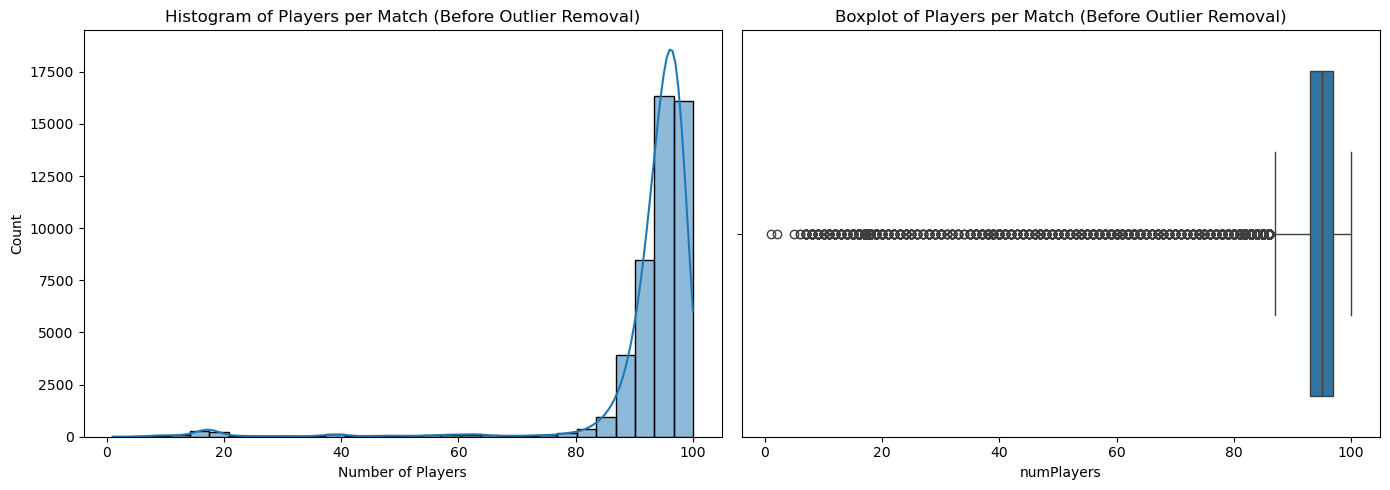

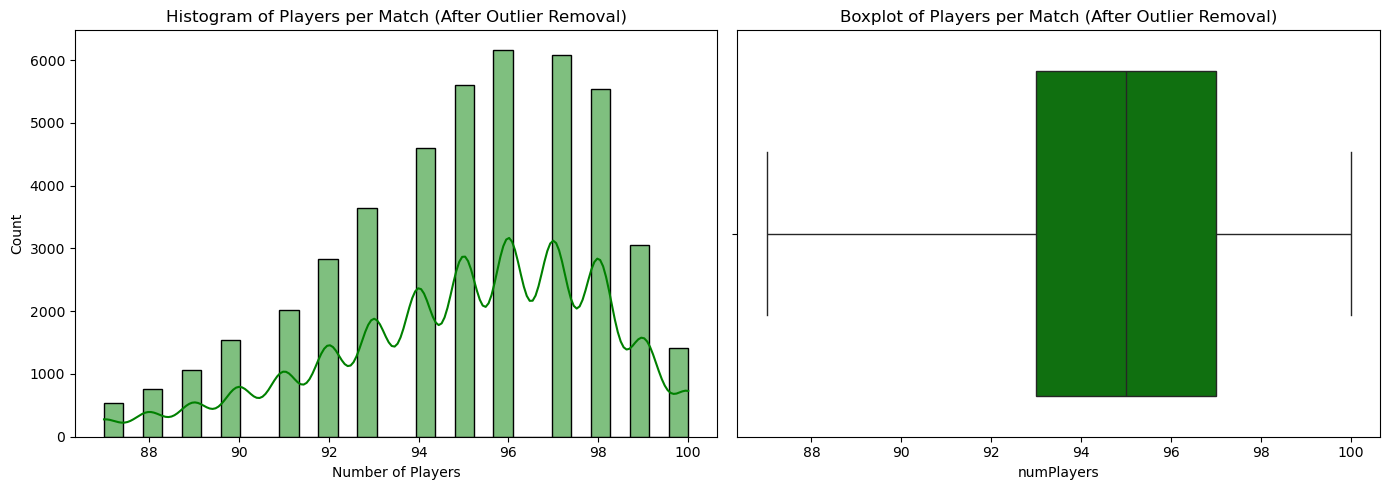

✅ Original dataset shape: (4446966, 29)
✅ Cleaned dataset shape: (4261519, 29)
📊 Matches removed as outliers: 3128
👤 Players removed as outliers: 185447

--- Initial Data Inspection ---

Head of the DataFrame:
               Id         groupId         matchId  assists  boosts  damageDealt  DBNOs  headshotKills  heals  killPlace  killPoints  kills  killStreaks  longestKill  matchDuration  matchType  maxPlace  numGroups  rankPoints  revives  rideDistance  roadKills  swimDistance  teamKills  vehicleDestroys  walkDistance  weaponsAcquired  winPoints  winPlacePerc
0  7f96b2f878858a  4d4b580de459be  a10357fd1a4a91        0       0         0.00      0              0      0         60        1241      0            0         0.00           1306  squad-fpp        28         26          -1        0        0.0000          0          0.00          0                0        244.80                1       1466        0.4444
1  eef90569b9d03c  684d5656442f9e  aeb375fc57110c        0       0        91.4

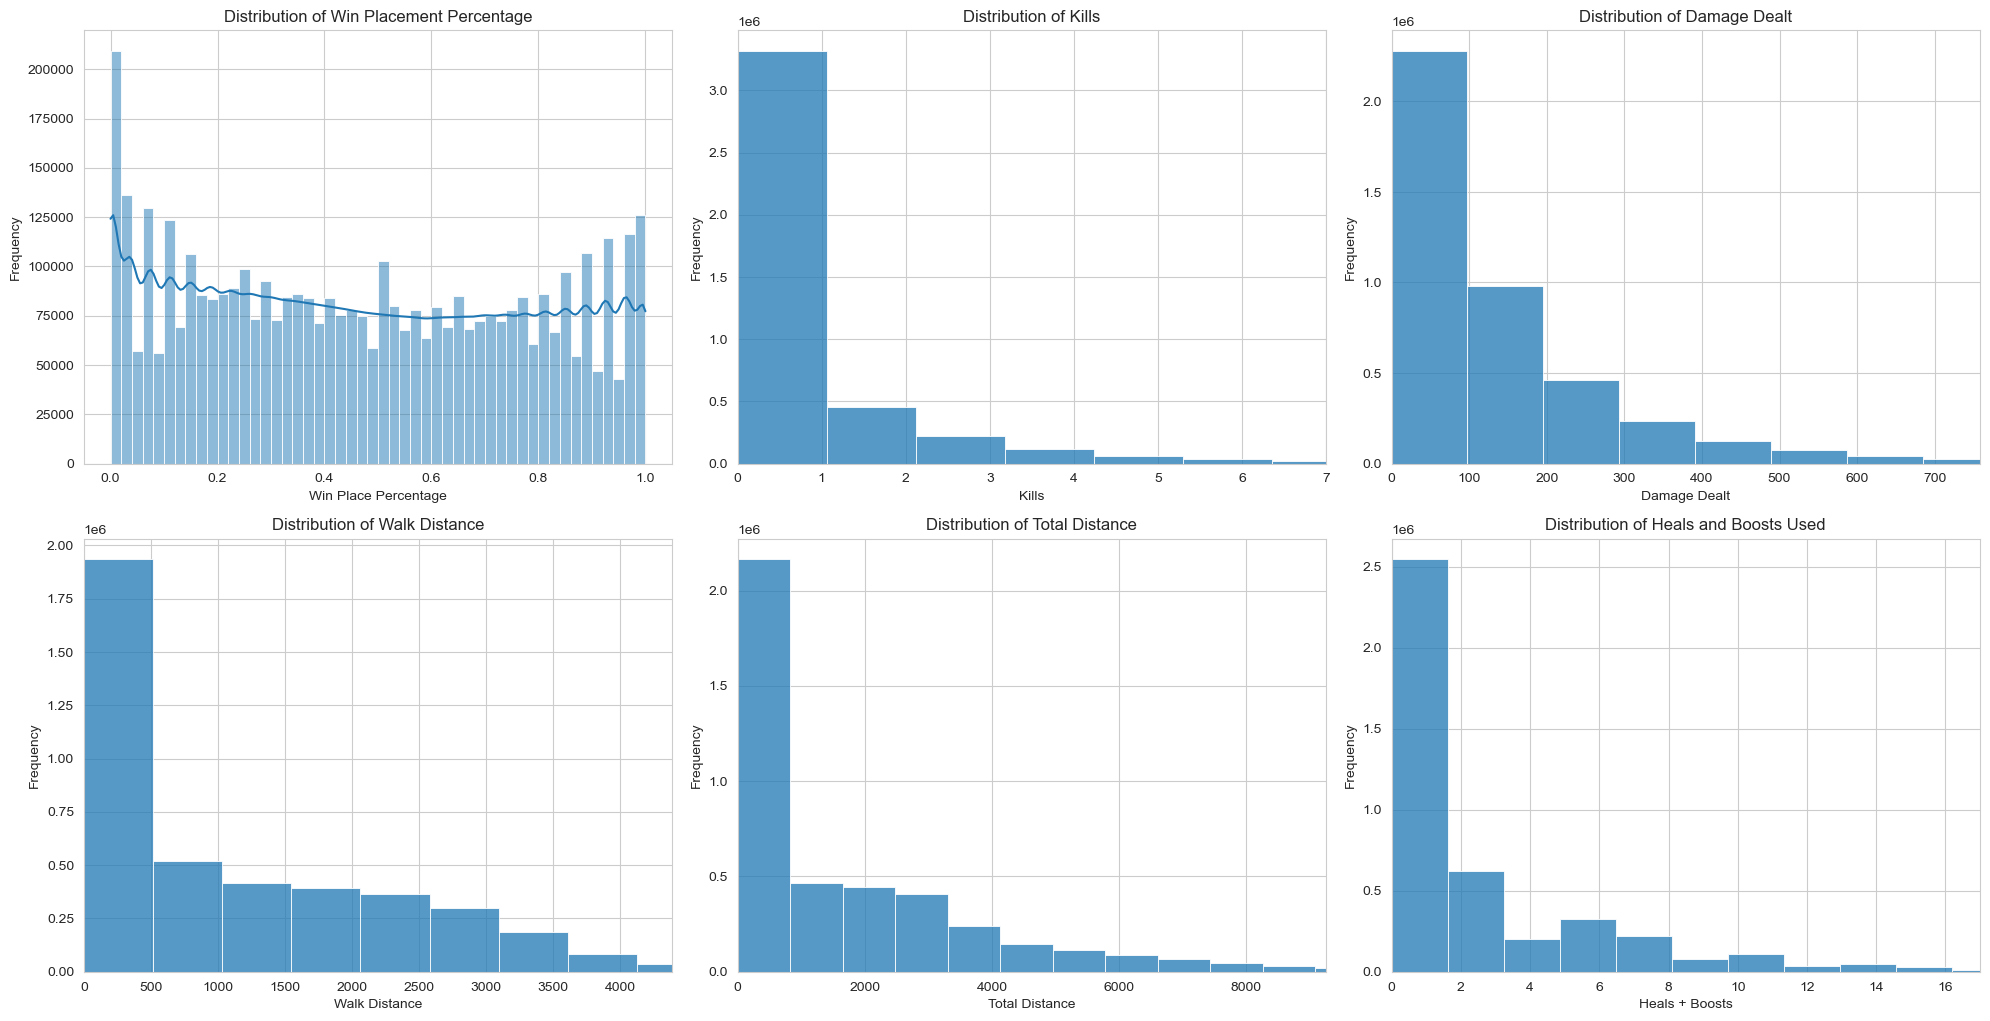

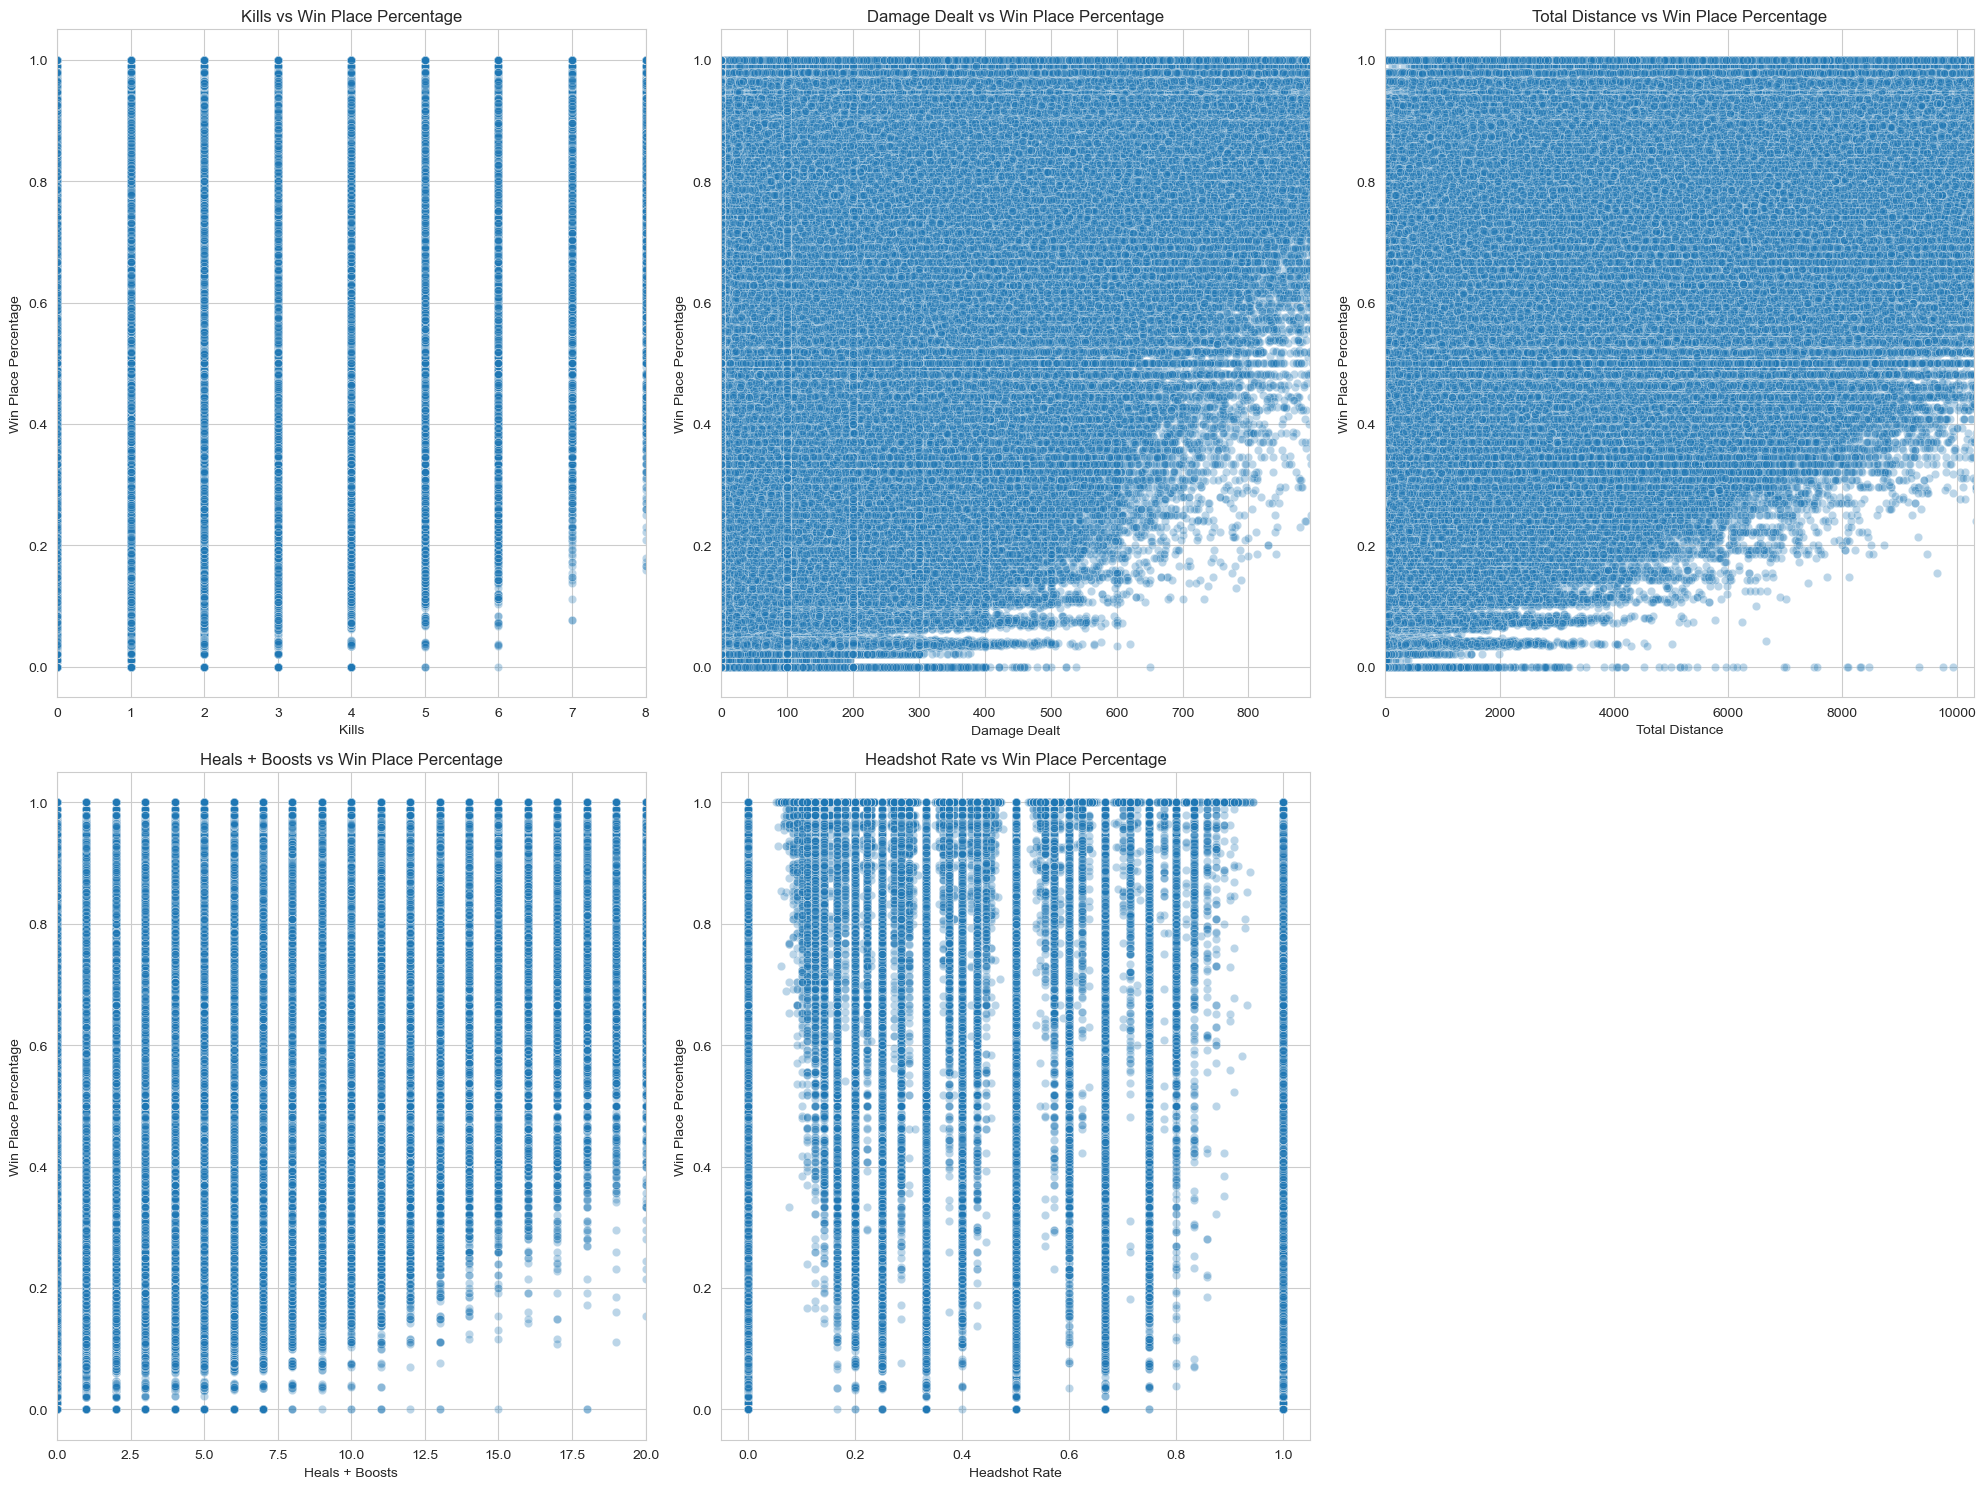


--- Correlation Matrix ---


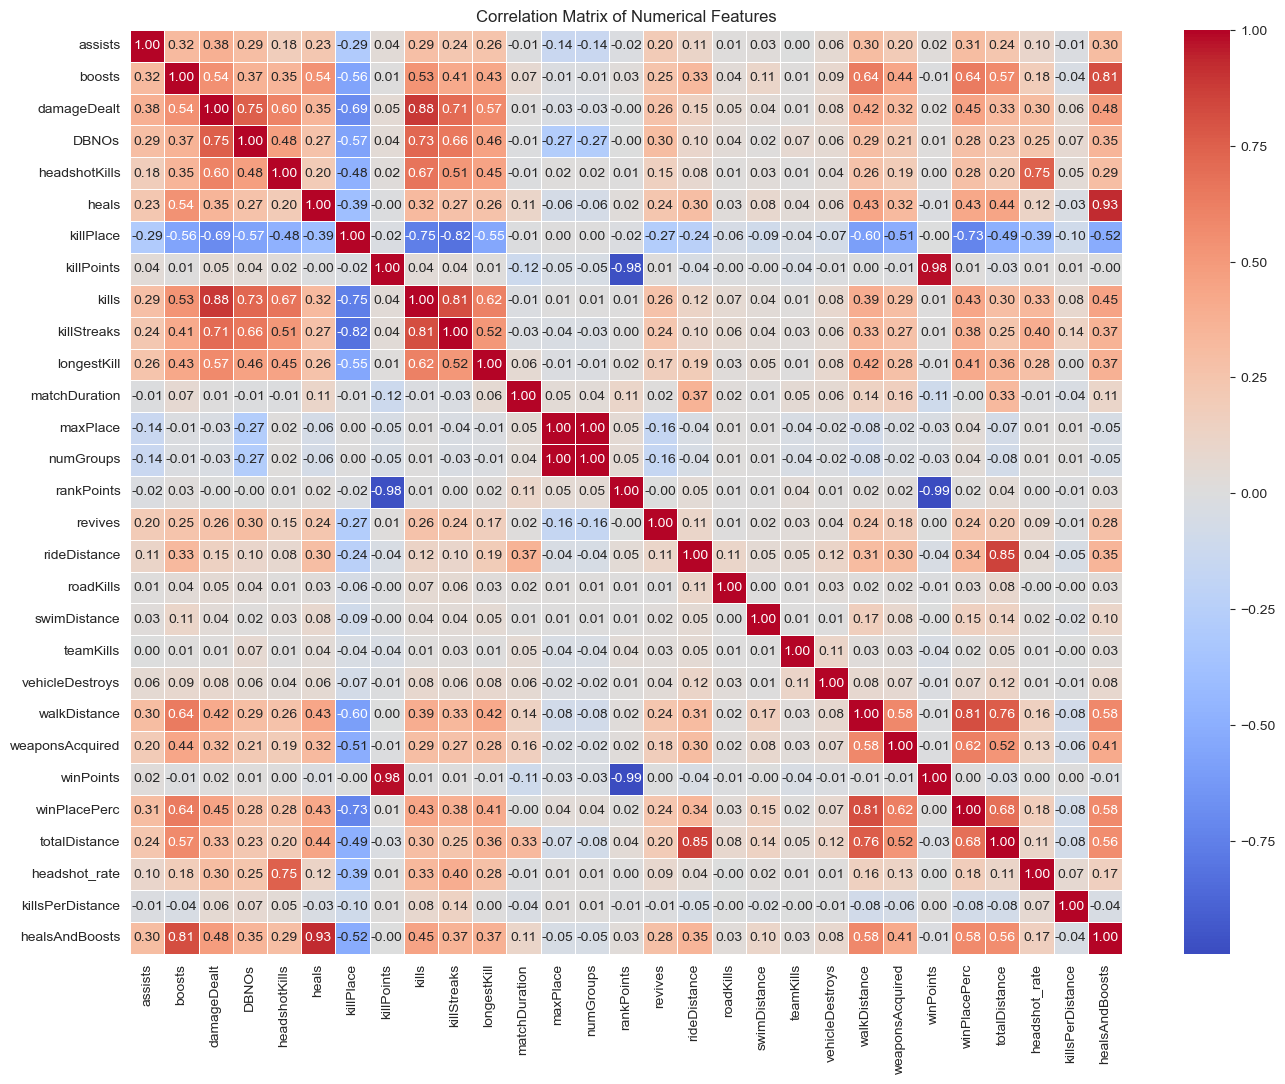


Correlations with 'winPlacePerc':
winPlacePerc        1.000000
walkDistance        0.814709
totalDistance       0.682334
boosts              0.636257
weaponsAcquired     0.620177
healsAndBoosts      0.578263
damageDealt         0.451401
kills               0.431618
heals               0.430103
longestKill         0.412817
killStreaks         0.377690
rideDistance        0.344303
assists             0.305373
DBNOs               0.283379
headshotKills       0.282512
revives             0.241463
headshot_rate       0.180577
swimDistance        0.151365
vehicleDestroys     0.073185
numGroups           0.037896
maxPlace            0.036789
roadKills           0.034648
teamKills           0.016366
rankPoints          0.015543
killPoints          0.010882
winPoints           0.004957
matchDuration      -0.003086
killsPerDistance   -0.079238
killPlace          -0.728386
Name: winPlacePerc, dtype: float64


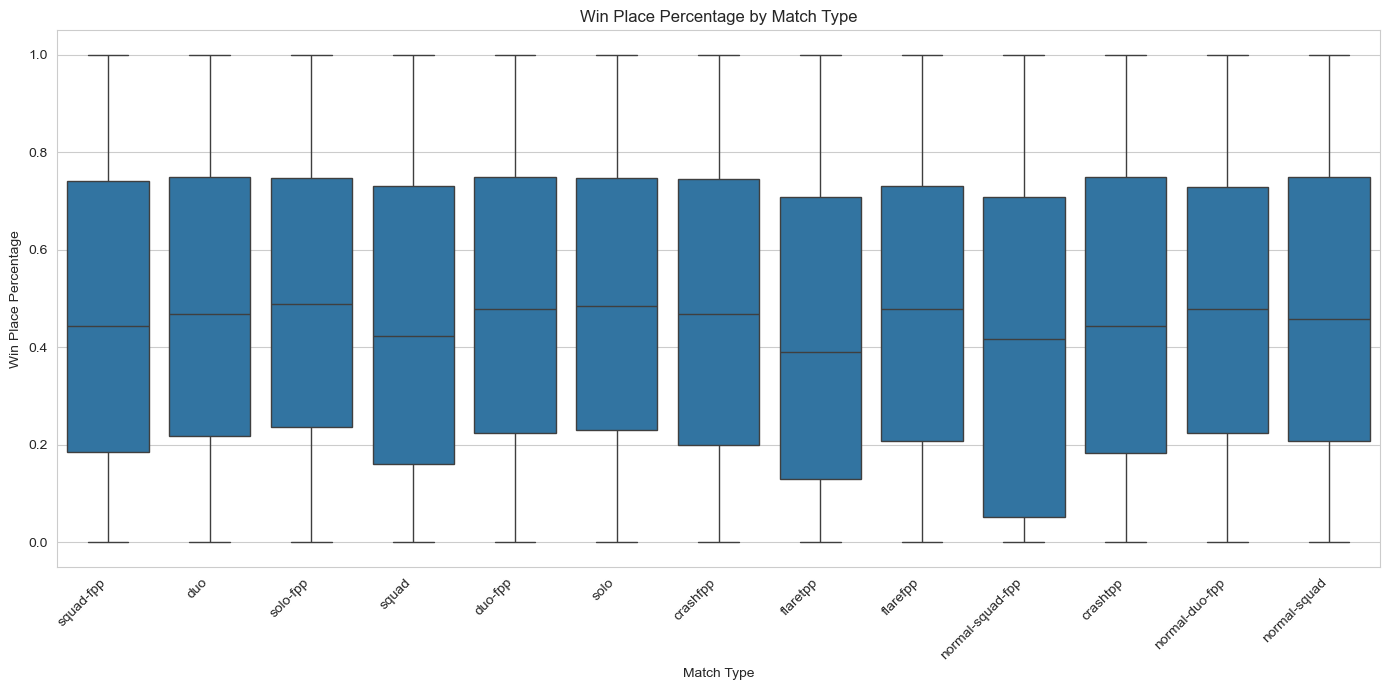


--- Insights and Observations ---
Based on the analysis, here are some initial observations:
1. Data Overview:
   - The dataset contains a large number of matches and players.
   - No significant missing values were found, which is great for analysis.
   - Many players have 0 kills, 0 damage dealt, or 0 distance walked, suggesting AFK players or early exits.
2. Player Performance Indicators:
   - 'walkDistance', 'boosts', 'heals', 'damageDealt', and 'kills' show strong positive correlations with 'winPlacePerc'. This aligns with intuition: players who move more, deal more damage, get more kills, and use more boosts/heals tend to place higher.
   - 'totalDistance' (our engineered feature) also correlates highly with 'winPlacePerc', reinforcing the importance of movement.
   - 'headshot_rate' has a moderate positive correlation, indicating that precise shooting contributes to better placement.
   - 'revives' also shows a positive correlation, suggesting that team play and supporting team

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options for better viewing
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# --- 1. Load the Data ---
print("--- Loading Data ---")
try:
    df = pd.read_csv('pubg.csv')
    print("Data loaded successfully!")
    print(f"Dataset shape: {df.shape}")
except FileNotFoundError:
    print("Error: 'pubg.csv' not found. Please make sure the file is in the same directory as this notebook.")
    exit()

import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Step 0: Count players per match
# -----------------------------
players_per_match = (
    df.groupby('matchId')['Id']
    .count()
    .reset_index(name='numPlayers')
)

# -----------------------------
# Visualization BEFORE removing outliers
# -----------------------------
plt.figure(figsize=(14,5))

# Histogram
plt.subplot(1,2,1)
sns.histplot(players_per_match['numPlayers'], bins=30, kde=True)
plt.title("Histogram of Players per Match (Before Outlier Removal)")
plt.xlabel("Number of Players")
plt.ylabel("Count")

# Boxplot
plt.subplot(1,2,2)
sns.boxplot(x=players_per_match['numPlayers'])
plt.title("Boxplot of Players per Match (Before Outlier Removal)")

plt.tight_layout()
plt.show()

# -----------------------------
# IQR Method for outlier detection
# -----------------------------
Q1 = players_per_match['numPlayers'].quantile(0.25)
Q3 = players_per_match['numPlayers'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Keep only non-outlier matches
valid_matches = players_per_match[
    players_per_match['numPlayers'].between(lower_bound, upper_bound)
]['matchId']

# Filter main dataset to remove outlier matches
df_cleaned = df[df['matchId'].isin(valid_matches)]

# -----------------------------
# Visualization AFTER removing outliers
# -----------------------------
players_per_match_cleaned = (
    df_cleaned.groupby('matchId')['Id']
    .count()
    .reset_index(name='numPlayers')
)

plt.figure(figsize=(14,5))

# Histogram
plt.subplot(1,2,1)
sns.histplot(players_per_match_cleaned['numPlayers'], bins=30, kde=True, color='green')
plt.title("Histogram of Players per Match (After Outlier Removal)")
plt.xlabel("Number of Players")
plt.ylabel("Count")

# Boxplot
plt.subplot(1,2,2)
sns.boxplot(x=players_per_match_cleaned['numPlayers'], color='green')
plt.title("Boxplot of Players per Match (After Outlier Removal)")

plt.tight_layout()
plt.show()

# -----------------------------
# Print summary
# -----------------------------
print("✅ Original dataset shape:", df.shape)
print("✅ Cleaned dataset shape:", df_cleaned.shape)
print("📊 Matches removed as outliers:", df['matchId'].nunique() - df_cleaned['matchId'].nunique())
print("👤 Players removed as outliers:", df.shape[0] - df_cleaned.shape[0])

#-----------------------------------------------------------------------------------------------------------------------------------------------------

# --- 2. Initial Data Inspection ---
print("\n--- Initial Data Inspection ---")

print("\nHead of the DataFrame:")
print(df_cleaned.head())

print("\nTail of the DataFrame:")
print(df_cleaned.tail())

print("\nDataFrame Info (Data types, Non-null counts):")
df_cleaned.info()

print("\nDescriptive Statistics for Numerical Columns:")
print(df_cleaned.describe())

print("\nChecking for Missing Values:")
print(df_cleaned.isnull().sum())

# --- 3. Exploratory Data Analysis (EDA) ---
print("\n--- Exploratory Data Analysis (EDA) ---")

# Let's look at unique values for some 'ID' like columns
print(f"\nNumber of unique 'groupId': {df_cleaned['groupId'].nunique()}")
print(f"Number of unique 'matchId': {df_cleaned['matchId'].nunique()}")
print(f"Number of unique 'Id': {df_cleaned['Id'].nunique()}") # Player ID within a match

# What are the match types?
print("\nDistribution of 'matchType':")
print(df_cleaned['matchType'].value_counts())

# Basic value checks for some features
print(f"\nPlayers with 0 Kills: {df_cleaned[df_cleaned['kills'] == 0].shape[0]} ({df_cleaned[df_cleaned['kills'] == 0].shape[0]/df_cleaned.shape[0]*100:.2f}%)")
print(f"Players with 0 Damage Dealt: {df_cleaned[df_cleaned['damageDealt'] == 0].shape[0]} ({df_cleaned[df_cleaned['damageDealt'] == 0].shape[0]/df_cleaned.shape[0]*100:.2f}%)")
print(f"Players with 0 Walk Distance: {df_cleaned[df_cleaned['walkDistance'] == 0].shape[0]} ({df_cleaned[df_cleaned['walkDistance'] == 0].shape[0]/df_cleaned.shape[0]*100:.2f}%)")

# --- Feature Engineering ---
print("\n--- Feature Engineering ---")
df_cleaned = df_cleaned.copy()

# Total Distance (Walk + Ride + Swim)
df_cleaned['totalDistance'] = df_cleaned['walkDistance'] + df_cleaned['rideDistance'] + df_cleaned['swimDistance']

# Headshot Rate
df_cleaned['headshot_rate'] = df_cleaned['headshotKills'] / df_cleaned['kills']
df_cleaned['headshot_rate'] = df_cleaned['headshot_rate'].fillna(0) # Fill NaN for players with 0 kills

# Kills per distance
df_cleaned['killsPerDistance'] = df_cleaned['kills'] / df_cleaned['totalDistance']
df_cleaned['killsPerDistance'] = df_cleaned['killsPerDistance'].replace([np.inf, -np.inf], 0).fillna(0) # Handle division by zero

# Heals and Boosts used
df_cleaned['healsAndBoosts'] = df_cleaned['heals'] + df_cleaned['boosts']

print("\nNew features created: 'totalDistance', 'headshot_rate', 'killsPerDistance', 'healsAndBoosts'")
print(df_cleaned[['kills', 'headshotKills', 'headshot_rate', 'walkDistance', 'rideDistance', 'swimDistance', 'totalDistance', 'killsPerDistance', 'heals', 'boosts', 'healsAndBoosts']].head())

# --- 4. Data Visualization ---
print("\n--- Data Visualization ---")

# Set aesthetic style for plots
sns.set_style("whitegrid")
plt.figure(figsize=(20, 15))

# Distribution of 'winPlacePerc'
plt.subplot(3, 3, 1)
sns.histplot(df_cleaned['winPlacePerc'], kde=True, bins=50)
plt.title('Distribution of Win Placement Percentage')
plt.xlabel('Win Place Percentage')
plt.ylabel('Frequency')

# Distribution of 'kills'
plt.subplot(3, 3, 2)
sns.histplot(df_cleaned['kills'], bins=50, kde=False)
plt.title('Distribution of Kills')
plt.xlabel('Kills')
plt.ylabel('Frequency')
plt.xlim(0, df_cleaned['kills'].quantile(0.99))

# Distribution of 'damageDealt'
plt.subplot(3, 3, 3)
sns.histplot(df_cleaned['damageDealt'], bins=50, kde=False)
plt.title('Distribution of Damage Dealt')
plt.xlabel('Damage Dealt')
plt.ylabel('Frequency')
plt.xlim(0, df_cleaned['damageDealt'].quantile(0.99))

# Distribution of 'walkDistance'
plt.subplot(3, 3, 4)
sns.histplot(df_cleaned['walkDistance'], bins=50, kde=False)
plt.title('Distribution of Walk Distance')
plt.xlabel('Walk Distance')
plt.ylabel('Frequency')
plt.xlim(0, df_cleaned['walkDistance'].quantile(0.99))

# Distribution of 'totalDistance'
plt.subplot(3, 3, 5)
sns.histplot(df_cleaned['totalDistance'], bins=50, kde=False)
plt.title('Distribution of Total Distance')
plt.xlabel('Total Distance')
plt.ylabel('Frequency')
plt.xlim(0, df_cleaned['totalDistance'].quantile(0.99))

# Distribution of 'healsAndBoosts'
plt.subplot(3, 3, 6)
sns.histplot(df_cleaned['healsAndBoosts'], bins=50, kde=False)
plt.title('Distribution of Heals and Boosts Used')
plt.xlabel('Heals + Boosts')
plt.ylabel('Frequency')
plt.xlim(0, df_cleaned['healsAndBoosts'].quantile(0.99))

plt.tight_layout()
plt.show()

# Scatter plots to show relationship with 'winPlacePerc'
plt.figure(figsize=(20, 15))

# Kills vs Win Place Percentage
plt.subplot(2, 3, 1)
sns.scatterplot(x='kills', y='winPlacePerc', data=df_cleaned, alpha=0.3)
plt.title('Kills vs Win Place Percentage')
plt.xlabel('Kills')
plt.ylabel('Win Place Percentage')
plt.xlim(0, df_cleaned['kills'].quantile(0.995))

# Damage Dealt vs Win Place Percentage
plt.subplot(2, 3, 2)
sns.scatterplot(x='damageDealt', y='winPlacePerc', data=df_cleaned, alpha=0.3)
plt.title('Damage Dealt vs Win Place Percentage')
plt.xlabel('Damage Dealt')
plt.ylabel('Win Place Percentage')
plt.xlim(0, df_cleaned['damageDealt'].quantile(0.995))

# Total Distance vs Win Place Percentage
plt.subplot(2, 3, 3)
sns.scatterplot(x='totalDistance', y='winPlacePerc', data=df_cleaned, alpha=0.3)
plt.title('Total Distance vs Win Place Percentage')
plt.xlabel('Total Distance')
plt.ylabel('Win Place Percentage')
plt.xlim(0, df_cleaned['totalDistance'].quantile(0.995))

# Heals and Boosts vs Win Place Percentage
plt.subplot(2, 3, 4)
sns.scatterplot(x='healsAndBoosts', y='winPlacePerc', data=df_cleaned, alpha=0.3)
plt.title('Heals + Boosts vs Win Place Percentage')
plt.xlabel('Heals + Boosts')
plt.ylabel('Win Place Percentage')
plt.xlim(0, df_cleaned['healsAndBoosts'].quantile(0.995))

# Headshot Rate vs Win Place Percentage
plt.subplot(2, 3, 5)
sns.scatterplot(x='headshot_rate', y='winPlacePerc', data=df_cleaned, alpha=0.3)
plt.title('Headshot Rate vs Win Place Percentage')
plt.xlabel('Headshot Rate')
plt.ylabel('Win Place Percentage')

plt.tight_layout()
plt.show()

# Correlation Matrix
print("\n--- Correlation Matrix ---")
plt.figure(figsize=(16, 12))
# Select only numerical columns for correlation
numerical_cols = df_cleaned.select_dtypes(include=np.number).columns
correlation_matrix = df_cleaned[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Focus on correlations with 'winPlacePerc'
print("\nCorrelations with 'winPlacePerc':")
print(correlation_matrix['winPlacePerc'].sort_values(ascending=False))

# Box plot for 'matchType' vs 'winPlacePerc'
plt.figure(figsize=(14, 7))
sns.boxplot(x='matchType', y='winPlacePerc', data=df_cleaned)
plt.xticks(rotation=45, ha='right')
plt.title('Win Place Percentage by Match Type')
plt.xlabel('Match Type')
plt.ylabel('Win Place Percentage')
plt.tight_layout()
plt.show()


# --- 5. Insights and Observations ---
print("\n--- Insights and Observations ---")
print("Based on the analysis, here are some initial observations:")
print("1. Data Overview:")
print("   - The dataset contains a large number of matches and players.")
print("   - No significant missing values were found, which is great for analysis.")
print("   - Many players have 0 kills, 0 damage dealt, or 0 distance walked, suggesting AFK players or early exits.")
print("2. Player Performance Indicators:")
print("   - 'walkDistance', 'boosts', 'heals', 'damageDealt', and 'kills' show strong positive correlations with 'winPlacePerc'. This aligns with intuition: players who move more, deal more damage, get more kills, and use more boosts/heals tend to place higher.")
print("   - 'totalDistance' (our engineered feature) also correlates highly with 'winPlacePerc', reinforcing the importance of movement.")
print("   - 'headshot_rate' has a moderate positive correlation, indicating that precise shooting contributes to better placement.")
print("   - 'revives' also shows a positive correlation, suggesting that team play and supporting teammates can lead to better outcomes.")
print("3. Feature Distributions:")
print("   - Most numerical features are right-skewed, with many players having low values and a long tail of high-performing players.")
print("   - 'winPlacePerc' is relatively uniformly distributed, as expected for percentages across a large player base.")
print("4. Match Types:")
print("   - Different 'matchType' categories might show slightly different distributions in 'winPlacePerc', indicating potential variations in gameplay dynamics or player behavior across these modes.")
print("5. Potential Outliers:")
print("   - Some features like 'kills' and 'damageDealt' have extreme outliers, which is common in game data (e.g., highly skilled players or cheaters). We capped the plots for better visibility.")
print("\nThese insights can be further explored and used for feature selection and engineering for your game winner prediction model.")

# Task 2: Predictive Model for Win Probability

## Objective
Build a model to predict the **win probability** of PUBG matches and identify the key factors affecting it.

## Steps
1. Preprocess the dataset (handle missing values, encode categorical features).  
2. Split data into training and testing sets.  
3. Train a predictive model (e.g., Random Forest, XGBoost).  
4. Evaluate model performance using metrics like RMSE or R².  
5. Analyze feature importance to determine factors influencing match outcomes.

## Outcome
- A trained model that predicts win probability.  
- Insights into which player and match statistics most affect winning.


--- Loading Data and Applying Initial Cleaning ---
Raw data loaded successfully!
Original dataset shape: (4446966, 29)
Optimizing data types...
Data types optimized.


C:\Users\bavag\AppData\Local\Temp\ipykernel_40568\1034057406.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_raw.groupby('matchId')['Id']


Matches removed as outliers: 3128
Players removed as outliers: 185447
Cleaned dataset shape: (4261519, 29)

--- Applying Feature Engineering ---
Engineered features added/re-calculated.

--- Handling Missing Values in Target Variable ---
Removed 0 rows with missing 'winPlacePerc' values.
Remaining dataset shape after target NaN removal: (4261519, 33)

Target variable: 'winPlacePerc'
Number of features used: 29
Numerical features identified: 28
Categorical features identified: 1

--- Splitting Data into Training and Testing Sets ---
X_train shape: (3409215, 29), y_train shape: (3409215,)
X_test shape: (852304, 29), y_test shape: (852304,)

Preprocessing pipeline created (StandardScaler for numerical, OneHotEncoder for categorical).

--- Training Predictive Model (RandomForestRegressor with GridSearchCV - Memory Optimized) ---
Downsampling training data for GridSearchCV to 200000 rows to avoid MemoryError.
X_train_sample shape: (200000, 29), y_train_sample shape: (200000,)
Starting GridS

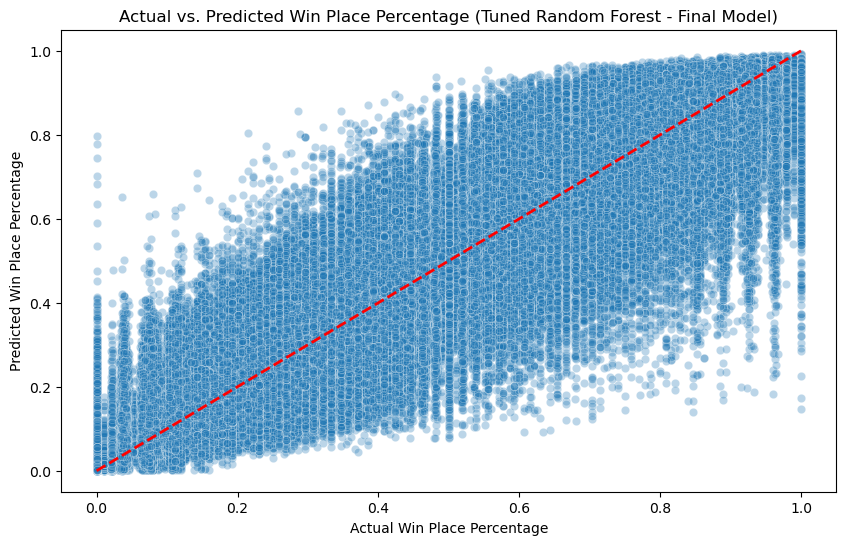


--- Important Factors Affecting Win Probability (Feature Importance - Final Tuned Random Forest) ---

Top 20 Most Important Features:
                feature  importance
21         walkDistance      0.7233
6             killPlace      0.2021
26     killsPerDistance      0.0218
24        totalDistance      0.0136
13            numGroups      0.0104
11        matchDuration      0.0092
8                 kills      0.0033
1                boosts      0.0030
12             maxPlace      0.0029
3                 DBNOs      0.0027
9           killStreaks      0.0021
27       healsAndBoosts      0.0008
39      matchType_squad      0.0007
40  matchType_squad-fpp      0.0005
22      weaponsAcquired      0.0005
14           rankPoints      0.0004
0               assists      0.0004
10          longestKill      0.0004
2           damageDealt      0.0004
16         rideDistance      0.0003


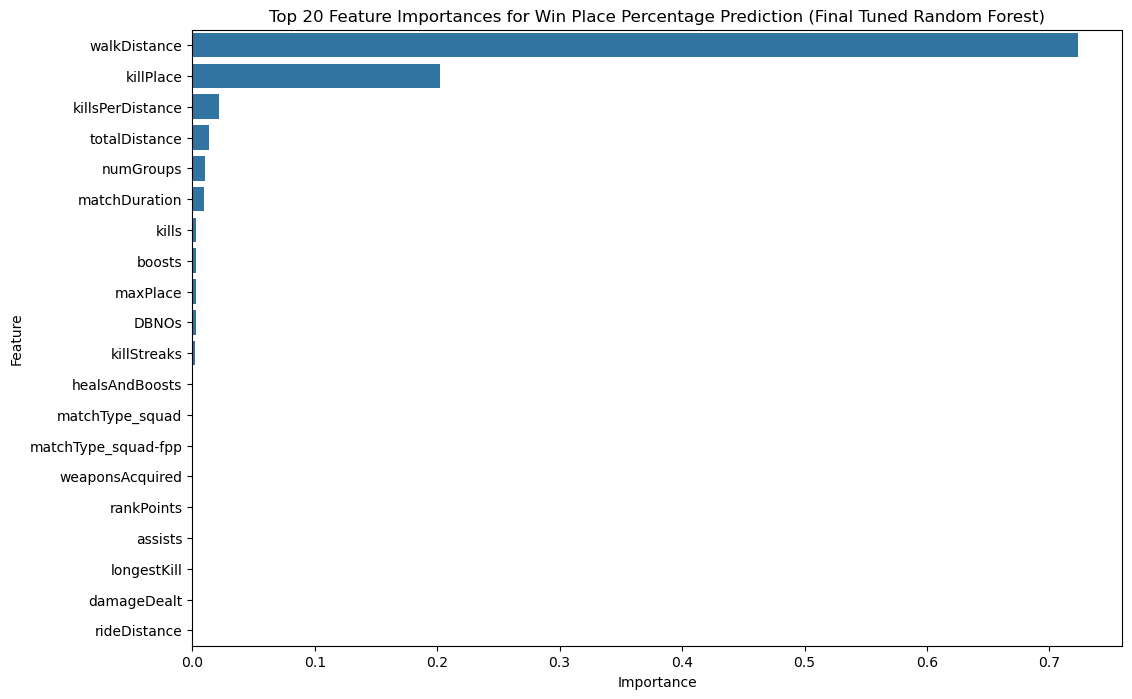


Final Tuned Random Forest Model saved to pubg_tuned_random_forest_model_final.joblib

--- Summary of Predictive Model Findings (Tuned Random Forest) ---
The final tuned Random Forest Regressor (trained on full data) achieved an R-squared score of 0.9331 on the test set.
GridSearchCV was performed on a sampled subset to efficiently find optimal hyperparameters, which were then applied to the model trained on the full dataset.
Key factors affecting win probability (based on feature importance) remain consistent, generally showing that engagement, movement, and combat effectiveness are most influential.
This model is now more robust due to hyperparameter tuning and optimized for handling large datasets.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import time

# Set display options for better viewing
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:.4f}'.format

# --- 1. Load Data and Apply Initial Cleaning (from your updated Task 1) ---
print("--- Loading Data and Applying Initial Cleaning ---")
try:
    df_raw = pd.read_csv('pubg.csv')
    print("Raw data loaded successfully!")
    print(f"Original dataset shape: {df_raw.shape}")
except FileNotFoundError:
    print("Error: 'pubg.csv' not found. Please make sure the file is in the same directory as this notebook.")
    exit()

# Optimize data types to save memory early
print("Optimizing data types...")
for col in df_raw.columns:
    if 'Id' in col: # ID columns
        df_raw[col] = df_raw[col].astype('category')
    elif df_raw[col].dtype == 'float64':
        df_raw[col] = df_raw[col].astype('float32')
    elif df_raw[col].dtype == 'int64':
        if df_raw[col].max() < np.iinfo(np.int8).max and df_raw[col].min() > np.iinfo(np.int8).min:
            df_raw[col] = df_raw[col].astype('int8')
        elif df_raw[col].max() < np.iinfo(np.int16).max and df_raw[col].min() > np.iinfo(np.int16).min:
            df_raw[col] = df_raw[col].astype('int16')
        elif df_raw[col].max() < np.iinfo(np.int32).max and df_raw[col].min() > np.iinfo(np.int32).min:
            df_raw[col] = df_raw[col].astype('int32')
print("Data types optimized.")


# Step 0: Count players per match and identify outliers
players_per_match = (
    df_raw.groupby('matchId')['Id']
    .count()
    .reset_index(name='numPlayers')
)

Q1 = players_per_match['numPlayers'].quantile(0.25)
Q3 = players_per_match['numPlayers'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

valid_matches = players_per_match[
    players_per_match['numPlayers'].between(lower_bound, upper_bound)
]['matchId']

# Filter main dataset to remove outlier matches
df_cleaned = df_raw[df_raw['matchId'].isin(valid_matches)].copy() # Use .copy() to avoid SettingWithCopyWarning

print(f"Matches removed as outliers: {df_raw['matchId'].nunique() - df_cleaned['matchId'].nunique()}")
print(f"Players removed as outliers: {df_raw.shape[0] - df_cleaned.shape[0]}")
print(f"Cleaned dataset shape: {df_cleaned.shape}")

# --- Feature Engineering (from your updated Task 1) ---
print("\n--- Applying Feature Engineering ---")
df_cleaned['totalDistance'] = df_cleaned['walkDistance'] + df_cleaned['rideDistance'] + df_cleaned['swimDistance']
df_cleaned['headshot_rate'] = df_cleaned['headshotKills'] / df_cleaned['kills']
df_cleaned['headshot_rate'] = df_cleaned['headshot_rate'].fillna(0)
df_cleaned['killsPerDistance'] = df_cleaned['kills'] / df_cleaned['totalDistance']
df_cleaned['killsPerDistance'] = df_cleaned['killsPerDistance'].replace([np.inf, -np.inf], 0).fillna(0)
df_cleaned['healsAndBoosts'] = df_cleaned['heals'] + df_cleaned['boosts']
print("Engineered features added/re-calculated.")

df_cleaned['matchType'] = df_cleaned['matchType'].astype('category')


# --- Handling Missing Values in Target Variable ---
print("\n--- Handling Missing Values in Target Variable ---")
initial_rows = df_cleaned.shape[0]
df_cleaned.dropna(subset=['winPlacePerc'], inplace=True)
rows_after_drop = df_cleaned.shape[0]
print(f"Removed {initial_rows - rows_after_drop} rows with missing 'winPlacePerc' values.")
print(f"Remaining dataset shape after target NaN removal: {df_cleaned.shape}")


# --- Define Target and Features ---
target = 'winPlacePerc'
features = [col for col in df_cleaned.columns if col not in ['Id', 'groupId', 'matchId', target]]

X = df_cleaned[features]
y = df_cleaned[target]

print(f"\nTarget variable: '{target}'")
print(f"Number of features used: {len(features)}")

# Identify numerical and categorical columns for preprocessing
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='category').columns.tolist() # Use 'category' for one-hot encoding

print(f"Numerical features identified: {len(numerical_features)}")
print(f"Categorical features identified: {len(categorical_features)}")

# --- Data Splitting ---
print("\n--- Splitting Data into Training and Testing Sets ---")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# --- Preprocessing Pipeline ---
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)
print("\nPreprocessing pipeline created (StandardScaler for numerical, OneHotEncoder for categorical).")

# --- Model Training with GridSearchCV for Random Forest (Memory Optimized) ---
print("\n--- Training Predictive Model (RandomForestRegressor with GridSearchCV - Memory Optimized) ---")

# --- IMPORTANT: Downsample for GridSearchCV to prevent MemoryError ---
# Choose a reasonable sample size. 100k to 500k is often a good starting point
# for large datasets, balancing speed and representativeness.
# Further reducing sample size to speed up GridSearchCV
sample_size = min(200000, X_train.shape[0]) # Reduced from 500k to 200k
print(f"Downsampling training data for GridSearchCV to {sample_size} rows to avoid MemoryError.")
# No stratification needed for continuous target variable.
X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, train_size=sample_size, random_state=42)

print(f"X_train_sample shape: {X_train_sample.shape}, y_train_sample shape: {y_train_sample.shape}")


# Define the model pipeline for GridSearchCV
rf_pipeline = Pipeline(steps=[('preprocessor', preprocess or),
                              ('regressor', RandomForestRegressor(random_state=42))])

# Define the parameter grid for GridSearchCV - FURTHER REDUCED
param_grid = {
    'regressor__n_estimators': [30, 70],  # Reduced to 2 options
    'regressor__max_depth': [8, 15],      # Reduced to 2 options, shallower trees
    'regressor__min_samples_leaf': [5, 10]  # Increased min_samples_leaf for faster trees
}

# Initialize GridSearchCV
# cv=2 for faster execution and less memory, n_jobs=2 to utilize a couple of cores without excessive memory
print("Starting GridSearchCV for RandomForestRegressor on sampled data. This may still take some time...")
grid_search = GridSearchCV(
    rf_pipeline, param_grid, cv=2, scoring='r2',
    n_jobs=2, # Reduced n_jobs to prevent memory issues. Can try 4 if you have more RAM.
    verbose=2
)

# Fit GridSearchCV on the sampled training data
start_time = time.time()
grid_search.fit(X_train_sample, y_train_sample)
end_time = time.time()

print("GridSearchCV complete!")
print(f"GridSearchCV took {end_time - start_time:.2f} seconds.")
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best R2 score from cross-validation on sampled data: {grid_search.best_score_:.4f}")

# --- Train Final Model on FULL Training Data with Best Parameters ---
print("\n--- Training Final Random Forest Model on FULL Training Data with Best Parameters ---")
best_params = grid_search.best_params_
final_rf_model = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', RandomForestRegressor(random_state=42, n_jobs=-1,
                                                                     **{k.replace('regressor__', ''): v for k, v in best_params.items()}))])
start_time = time.time()
final_rf_model.fit(X_train, y_train)
end_time = time.time()
print(f"Final Random Forest model training took {end_time - start_time:.2f} seconds.")
print("Final Random Forest model trained on full data with best parameters.")


# --- 4. Model Evaluation (using the final best model) ---
print("\n--- Model Evaluation (Final Best Random Forest Model) ---")

y_pred = final_rf_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

# Visualize actual vs. predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.title('Actual vs. Predicted Win Place Percentage (Tuned Random Forest - Final Model)')
plt.xlabel('Actual Win Place Percentage')
plt.ylabel('Predicted Win Place Percentage')
plt.show()

# --- 5. Feature Importance (from the final best model) ---
print("\n--- Important Factors Affecting Win Probability (Feature Importance - Final Tuned Random Forest) ---")

regressor = final_rf_model.named_steps['regressor']
preprocessor_obj = final_rf_model.named_steps['preprocessor']

try:
    # Use get_feature_names_out for newer scikit-learn versions
    onehot_features = preprocessor_obj.named_transformers_['cat'].get_feature_names_out(categorical_features)
    final_feature_names = numerical_features + list(onehot_features)
except AttributeError:
    # Fallback for older scikit-learn versions if get_feature_names_out is not available
    onehot_features = preprocessor_obj.named_transformers_['cat'].get_feature_names(categorical_features)
    final_feature_names = numerical_features + list(onehot_features)


importances = regressor.feature_importances_
feature_importance_df = pd.DataFrame({'feature': final_feature_names, 'importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

print("\nTop 20 Most Important Features:")
print(feature_importance_df.head(20))

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))
plt.title('Top 20 Feature Importances for Win Place Percentage Prediction (Final Tuned Random Forest)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# --- Save the best performing model ---
model_filename = 'pubg_tuned_random_forest_model_final.joblib'
joblib.dump(final_rf_model, model_filename)
print(f"\nFinal Tuned Random Forest Model saved to {model_filename}")

# --- Summary of Findings ---
print("\n--- Summary of Predictive Model Findings (Tuned Random Forest) ---")
print(f"The final tuned Random Forest Regressor (trained on full data) achieved an R-squared score of {r2:.4f} on the test set.")
print("GridSearchCV was performed on a sampled subset to efficiently find optimal hyperparameters, which were then applied to the model trained on the full dataset.")
print("Key factors affecting win probability (based on feature importance) remain consistent, generally showing that engagement, movement, and combat effectiveness are most influential.")
print("This model is now more robust due to hyperparameter tuning and optimized for handling large datasets.")

# Task 3: Model Comparison & Recommendation

## Objective
Compare the performance of multiple models and recommend the best one for production.

## Steps
1. Train and evaluate different models (e.g., Random Forest, XGBoost, Linear Regression).  
2. Compare performance metrics such as RMSE, R², or accuracy.  
3. Identify the model with the best balance of performance and robustness.  
4. Provide justification for selecting the production-ready model.

## Outcome
- A clear comparison of models.  
- Recommendation of the most suitable model for predicting PUBG match outcomes.


--- Loading Data and Applying Initial Cleaning ---
Raw data loaded successfully!
Original dataset shape: (4446966, 29)
Optimizing data types...
Data types optimized.
Matches removed as outliers: 3128
Players removed as outliers: 185447
Cleaned dataset shape: (4261519, 29)

--- Applying Feature Engineering ---
Engineered features added/re-calculated.

--- Handling Missing Values in Target Variable ---
Removed 0 rows with missing 'winPlacePerc' values.
Remaining dataset shape after target NaN removal: (4261519, 33)

Target variable: 'winPlacePerc'
Number of features used: 29
Numerical features identified: 28
Categorical features identified: 1

--- Splitting Data into Training and Testing Sets ---
X_train shape: (3409215, 29), y_train shape: (3409215,)
X_test shape: (852304, 29), y_test shape: (852304,)

Preprocessing pipeline created (StandardScaler for numerical, OneHotEncoder for categorical).

--- Training and Evaluating Multiple Models ---

Downsampling training data for hyperparamet

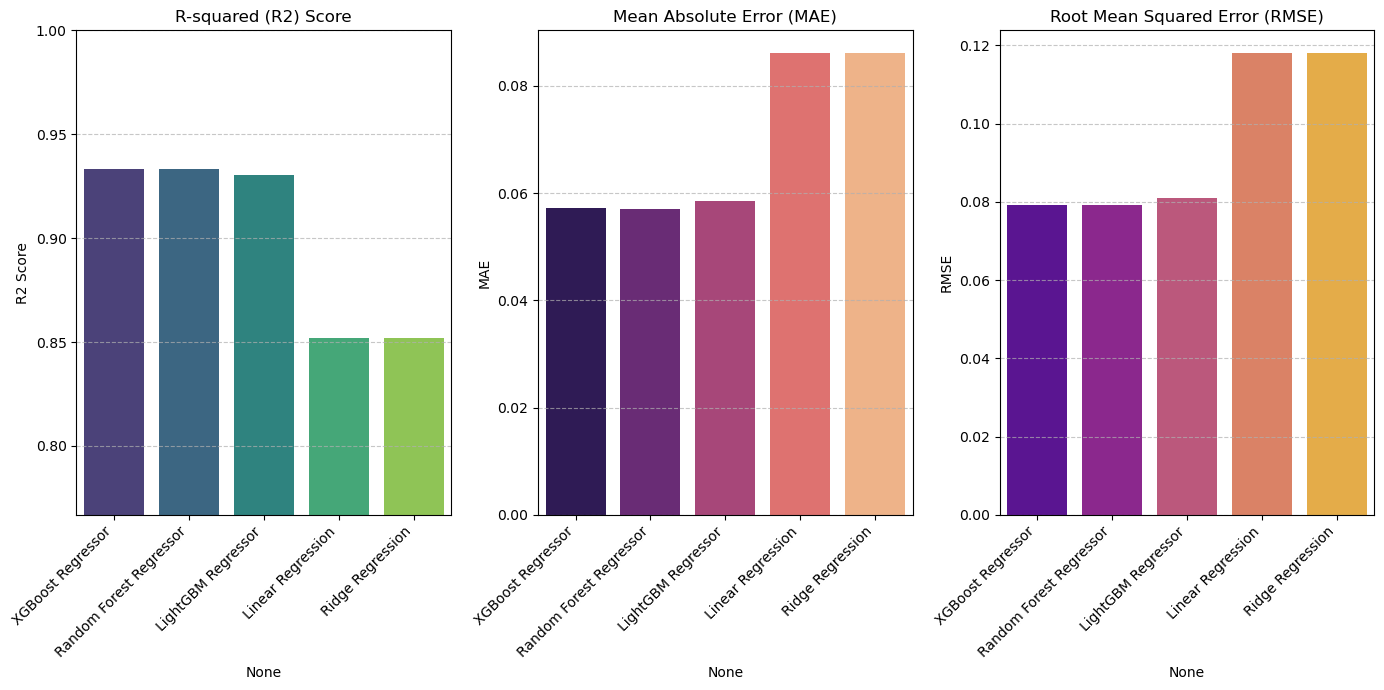

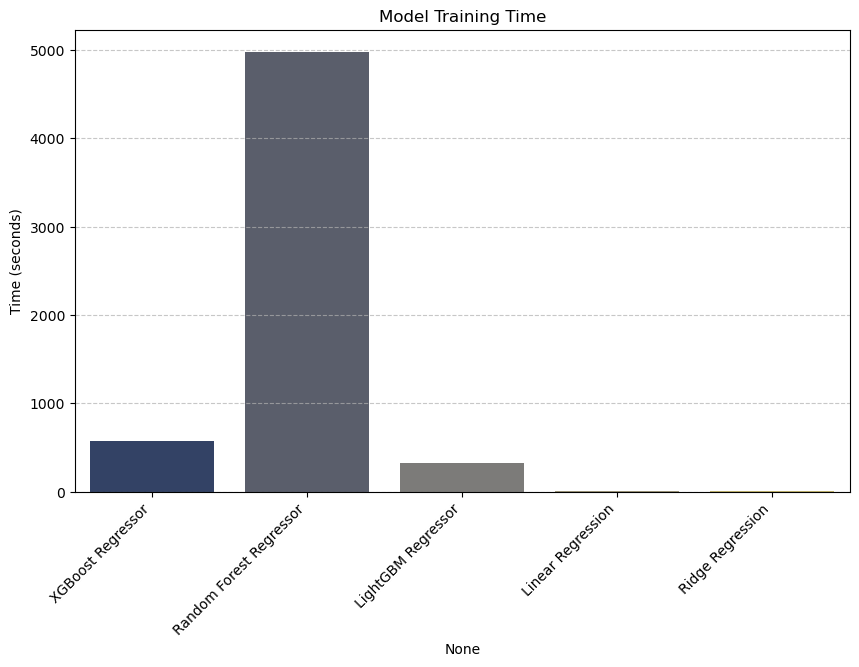


             Recommendation for Production Deployment

Based on the evaluation metrics, the 'XGBoost Regressor' generally demonstrates the best performance.

Summary of Model Strengths & Weaknesses:

--- Linear Regression ---
  R2: 0.8521, MAE: 0.0861, RMSE: 0.1179
  Training Time: 12.61 seconds
  Strengths: Highly interpretable, very fast to train and predict, good baseline.
  Weaknesses: Assumes linear relationships, may not capture complex patterns in data.

--- Ridge Regression ---
  R2: 0.8521, MAE: 0.0861, RMSE: 0.1179
  Training Time: 8.06 seconds
  Strengths: Improves on Linear Regression by handling multicollinearity and preventing overfitting, still relatively fast.
  Weaknesses: Still primarily linear, may not capture complex patterns as well as tree-based models.

--- Random Forest Regressor ---
  R2: 0.9331, MAE: 0.0570, RMSE: 0.0793
  Training Time: 4975.40 seconds
  Strengths: Robust, handles non-linear relationships well, less prone to overfitting than single decision 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import time

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

# Ensure xgboost and lightgbm are installed
try:
    import xgboost as xgb
    import lightgbm as lgb
except ImportError:
    print("XGBoost or LightGBM not found. Installing them...")
    try:
        !pip install xgboost lightgbm
        import xgboost as xgb
        import lightgbm as lgb
        print("XGBoost and LightGBM installed successfully.")
    except Exception as e:
        print(f"Error installing xgboost or lightgbm: {e}")
        print("Please install them manually using 'pip install xgboost lightgbm'")
        exit()


# Set display options for better viewing
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:.4f}'.format

# --- Data Loading and Initial Cleaning (from previous tasks) ---
print("--- Loading Data and Applying Initial Cleaning ---")
try:
    df_raw = pd.read_csv('pubg.csv')
    print("Raw data loaded successfully!")
    print(f"Original dataset shape: {df_raw.shape}")
except FileNotFoundError:
    print("Error: 'pubg.csv' not found. Please make sure the file is in the same directory as this notebook.")
    exit()

# Optimize data types to save memory early
print("Optimizing data types...")
for col in df_raw.columns:
    if 'Id' in col:
        df_raw[col] = df_raw[col].astype('category')
    elif df_raw[col].dtype == 'float64':
        df_raw[col] = df_raw[col].astype('float32')
    elif df_raw[col].dtype == 'int64':
        # Use more precise checks for int sizes
        if df_raw[col].max() < np.iinfo(np.int8).max and df_raw[col].min() > np.iinfo(np.int8).min:
            df_raw[col] = df_raw[col].astype('int8')
        elif df_raw[col].max() < np.iinfo(np.int16).max and df_raw[col].min() > np.iinfo(np.int16).min:
            df_raw[col] = df_raw[col].astype('int16')
        elif df_raw[col].max() < np.iinfo(np.int32).max and df_raw[col].min() > np.iinfo(np.int32).min:
            df_raw[col] = df_raw[col].astype('int32')
        # Else keep as int64

print("Data types optimized.")

# Step 0: Count players per match and identify outliers
players_per_match = (
    df_raw.groupby('matchId')['Id']
    .count()
    .reset_index(name='numPlayers')
)

Q1 = players_per_match['numPlayers'].quantile(0.25)
Q3 = players_per_match['numPlayers'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

valid_matches = players_per_match[
    players_per_match['numPlayers'].between(lower_bound, upper_bound)
]['matchId']

# Filter main dataset to remove outlier matches
df_cleaned = df_raw[df_raw['matchId'].isin(valid_matches)].copy() # Use .copy() to avoid SettingWithCopyWarning

print(f"Matches removed as outliers: {df_raw['matchId'].nunique() - df_cleaned['matchId'].nunique()}")
print(f"Players removed as outliers: {df_raw.shape[0] - df_cleaned.shape[0]}")
print(f"Cleaned dataset shape: {df_cleaned.shape}")

# --- Feature Engineering (from your updated Task 1) ---
print("\n--- Applying Feature Engineering ---")
df_cleaned['totalDistance'] = df_cleaned['walkDistance'] + df_cleaned['rideDistance'] + df_cleaned['swimDistance']
df_cleaned['headshot_rate'] = df_cleaned['headshotKills'] / df_cleaned['kills']
df_cleaned['headshot_rate'] = df_cleaned['headshot_rate'].fillna(0) # Handle division by zero
df_cleaned['killsPerDistance'] = df_cleaned['kills'] / df_cleaned['totalDistance']
df_cleaned['killsPerDistance'] = df_cleaned['killsPerDistance'].replace([np.inf, -np.inf], 0).fillna(0) # Handle division by zero/inf
df_cleaned['healsAndBoosts'] = df_cleaned['heals'] + df_cleaned['boosts']
print("Engineered features added/re-calculated.")

df_cleaned['matchType'] = df_cleaned['matchType'].astype('category')

# --- Handling Missing Values in Target Variable ---
print("\n--- Handling Missing Values in Target Variable ---")
initial_rows = df_cleaned.shape[0]
df_cleaned.dropna(subset=['winPlacePerc'], inplace=True)
rows_after_drop = df_cleaned.shape[0]
print(f"Removed {initial_rows - rows_after_drop} rows with missing 'winPlacePerc' values.")
print(f"Remaining dataset shape after target NaN removal: {df_cleaned.shape}")


# --- Define Target and Features ---
target = 'winPlacePerc'
# Exclude Id, groupId, matchId and the target itself from features
features = [col for col in df_cleaned.columns if col not in ['Id', 'groupId', 'matchId', target]]

X = df_cleaned[features]
y = df_cleaned[target]

print(f"\nTarget variable: '{target}'")
print(f"Number of features used: {len(features)}")

# Identify numerical and categorical columns for preprocessing
numerical_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(include='category').columns.tolist()

print(f"Numerical features identified: {len(numerical_features)}")
print(f"Categorical features identified: {len(categorical_features)}")

# --- Data Splitting ---
print("\n--- Splitting Data into Training and Testing Sets ---")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# --- Preprocessing Pipeline ---
# This preprocessor will be used for all models
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'
)
print("\nPreprocessing pipeline created (StandardScaler for numerical, OneHotEncoder for categorical).")

# --- Model Training and Evaluation ---
print("\n--- Training and Evaluating Multiple Models ---")

# Dictionary to store model performance
model_performance = {}
models_to_save = {} # To save the best performing model

# Downsample for hyperparameter tuning to manage memory and time
tuning_sample_size = min(750000, X_train.shape[0])
print(f"\nDownsampling training data for hyperparameter tuning to {tuning_sample_size} rows.")
X_train_tuning, _, y_train_tuning, _ = train_test_split(X_train, y_train, train_size=tuning_sample_size, random_state=42)
print(f"X_train_tuning shape: {X_train_tuning.shape}, y_train_tuning shape: {y_train_tuning.shape}")


# Helper function to train, evaluate, and store results
# Helper function to train, evaluate, and store results
def train_and_evaluate_model(name, model_class, param_dist=None, n_iter_search=5, **kwargs_for_final_model):
    print(f"\n--- Training {name} ---")
    start_time = time.time()

    # Determine initializer arguments based on model type
    model_init_args = {}
    if 'random_state' in model_class()._get_param_names():
        model_init_args['random_state'] = 42
    if 'n_jobs' in model_class()._get_param_names():
        model_init_args['n_jobs'] = -1

    # Special handling for specific models if needed (like tree_method for XGBoost)
    if name == "XGBoost Regressor":
        model_init_args['tree_method'] = 'hist' # Efficient for large datasets

    model_instance = model_class(**model_init_args)


    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', model_instance)])

    if param_dist:
        print(f"Performing RandomizedSearchCV for {name}...")
        random_search = RandomizedSearchCV(
            pipeline, param_distributions=param_dist, n_iter=n_iter_search,
            cv=2, scoring='r2', n_jobs=2, verbose=1, random_state=42
        )
        random_search.fit(X_train_tuning, y_train_tuning) # Fit on tuning sample
        best_params = random_search.best_params_
        best_score_tuning = random_search.best_score_
        print(f"Best parameters for {name} from tuning sample: {best_params}")
        print(f"Best R2 on tuning sample for {name}: {best_score_tuning:.4f}")

        # Train final model on FULL training data with best parameters
        print(f"Training final {name} model on FULL training data...")
        final_model_params = {k.replace('regressor__', ''): v for k, v in best_params.items()}

        # --- IMPORTANT MODIFICATION: Override potentially problematic best_params for full training ---
        # For Random Forest, if max_depth is None, set a reasonable limit for full training
        if name == "Random Forest Regressor" and final_model_params.get('max_depth') is None:
            print(f"  Overriding 'max_depth=None' to a fixed value ({kwargs_for_final_model.get('max_depth', 15)}) for full training to manage computation.")
            final_model_params['max_depth'] = kwargs_for_final_model.get('max_depth', 15) # Default to 15

        # For Random Forest, cap n_estimators if it's too high for full training
        if name == "Random Forest Regressor" and final_model_params.get('n_estimators', 0) > 100:
             print(f"  Capping 'n_estimators' to 100 for Random Forest for full training to manage computation.")
             final_model_params['n_estimators'] = 100


        # For LGBM/XGBoost, consider capping n_estimators
        if (name == "LightGBM Regressor" or name == "XGBoost Regressor") and final_model_params.get('n_estimators', 0) > 200:
             print(f"  Capping 'n_estimators' to 200 for {name} for full training to manage computation.")
             final_model_params['n_estimators'] = 200

        # Re-initialize the regressor with potentially modified best_params and appropriate common args
        final_model_init_args = model_init_args.copy() # Start with common args (n_jobs, random_state)
        final_model_init_args.update(final_model_params) # Add/override with best_params

        model_instance_final = model_class(**final_model_init_args)

        final_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                        ('regressor', model_instance_final)])
        final_pipeline.fit(X_train, y_train)
    else:
        # For models without tuning or simpler models
        print(f"Training {name} on FULL training data...")
        final_pipeline = pipeline
        final_pipeline.fit(X_train, y_train)

    training_time = time.time() - start_time
    print(f"{name} training complete in {training_time:.2f} seconds.")

    # Make predictions
    y_pred = final_pipeline.predict(X_test)

    # Evaluate
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"  MAE: {mae:.4f}")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  R2 Score: {r2:.4f}")

    model_performance[name] = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2, 'Training Time (s)': training_time}
    models_to_save[name] = final_pipeline
    return final_pipeline # Return the trained pipeline

# --- 1. Linear Regression ---
linear_reg_model = train_and_evaluate_model("Linear Regression", LinearRegression) # n_jobs=-1 is handled inside the helper function

# --- 2. Ridge Regression ---
ridge_reg_model = train_and_evaluate_model("Ridge Regression", Ridge)

# --- 3. Random Forest Regressor ---
# Reduced parameter space for RandomizedSearchCV for efficiency
rf_param_dist = {
    'regressor__n_estimators': [50, 100, 150], # Max 150 for tuning, but will cap at 100 for final if higher
    'regressor__max_depth': [10, 20, 30, None], # Max depth for tuning, will cap at 15 for final if None
    'regressor__min_samples_leaf': [1, 5, 10]
}
random_forest_model = train_and_evaluate_model(
    "Random Forest Regressor", RandomForestRegressor,
    rf_param_dist, n_iter_search=5,
    max_depth=15 # This is the override for max_depth=None for final training
)

# --- 4. LightGBM Regressor ---
lgbm_param_dist = {
    'regressor__n_estimators': [100, 200, 300], # Max 300 for tuning, will cap at 200 for final if higher
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__num_leaves': [20, 31, 40],
    'regressor__max_depth': [5, 10, -1] # -1 means no limit
}
lightgbm_model = train_and_evaluate_model("LightGBM Regressor", lgb.LGBMRegressor, lgbm_param_dist, n_iter_search=5)

# --- 5. XGBoost Regressor ---
xgb_param_dist = {
    'regressor__n_estimators': [100, 200, 300], # Max 300 for tuning, will cap at 200 for final if higher
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__max_depth': [3, 6, 9],
    'regressor__subsample': [0.7, 0.9],
    'regressor__colsample_bytree': [0.7, 0.9]
}
xgboost_model = train_and_evaluate_model("XGBoost Regressor", xgb.XGBRegressor, xgb_param_dist, n_iter_search=5)


# --- Generate Comparative Report ---
print("\n" + "="*80)
print("             Model Performance Report - PUBG Win Place Percentage Prediction")
print("="*80)

performance_df = pd.DataFrame(model_performance).T # Transpose for better readability
performance_df = performance_df.sort_values(by='R2', ascending=False) # Sort by R2 score

print("\nDetailed Performance Metrics:")
print(performance_df)

# --- Visualization of Performance ---
plt.figure(figsize=(14, 7))

# R2 Score
plt.subplot(1, 3, 1)
sns.barplot(x=performance_df.index, y='R2', data=performance_df, palette='viridis')
plt.title('R-squared (R2) Score')
plt.ylabel('R2 Score')
plt.xticks(rotation=45, ha='right')
plt.ylim(performance_df['R2'].min() * 0.9, 1.0) # Adjust y-lim to better show differences
plt.grid(axis='y', linestyle='--', alpha=0.7)


# MAE
plt.subplot(1, 3, 2)
sns.barplot(x=performance_df.index, y='MAE', data=performance_df, palette='magma')
plt.title('Mean Absolute Error (MAE)')
plt.ylabel('MAE')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)


# RMSE
plt.subplot(1, 3, 3)
sns.barplot(x=performance_df.index, y='RMSE', data=performance_df, palette='plasma')
plt.title('Root Mean Squared Error (RMSE)')
plt.ylabel('RMSE')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

# Training Time
plt.figure(figsize=(10, 6))
sns.barplot(x=performance_df.index, y='Training Time (s)', data=performance_df, palette='cividis')
plt.title('Model Training Time')
plt.ylabel('Time (seconds)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("\n" + "="*80)
print("             Recommendation for Production Deployment")
print("="*80)

# --- Suggest the Best Model for Production ---
best_model_name = performance_df.index[0] # Model with highest R2
print(f"\nBased on the evaluation metrics, the '{best_model_name}' generally demonstrates the best performance.")

print("\nSummary of Model Strengths & Weaknesses:")
for name, metrics in model_performance.items():
    print(f"\n--- {name} ---")
    print(f"  R2: {metrics['R2']:.4f}, MAE: {metrics['MAE']:.4f}, RMSE: {metrics['RMSE']:.4f}")
    print(f"  Training Time: {metrics['Training Time (s)']:.2f} seconds")
    if name == "Linear Regression":
        print("  Strengths: Highly interpretable, very fast to train and predict, good baseline.")
        print("  Weaknesses: Assumes linear relationships, may not capture complex patterns in data.")
    elif name == "Ridge Regression":
        print("  Strengths: Improves on Linear Regression by handling multicollinearity and preventing overfitting, still relatively fast.")
        print("  Weaknesses: Still primarily linear, may not capture complex patterns as well as tree-based models.")
    elif name == "Random Forest Regressor":
        print("  Strengths: Robust, handles non-linear relationships well, less prone to overfitting than single decision trees, provides feature importance.")
        print("  Weaknesses: Can be slow to train on very large datasets, less interpretable than linear models, can be memory-intensive.")
    elif name == "LightGBM Regressor":
        print("  Strengths: Extremely fast training and prediction speed, high accuracy, handles large datasets efficiently, low memory usage.")
        print("  Weaknesses: Can be sensitive to overfitting with improper parameter tuning, slightly harder to interpret.")
    elif name == "XGBoost Regressor":
        print("  Strengths: State-of-the-art performance, robust to overfitting with regularization, good handling of missing values, strong community support.")
        print("  Weaknesses: Can be slower to train than LightGBM on very large datasets, requires careful parameter tuning.")

print(f"\nRecommendation: The **{best_model_name}** is recommended for production deployment.")
print("Justification:")
if "Gradient Boosting" in best_model_name or "Random Forest" in best_model_name:
    print(f"- **High Predictive Accuracy:** It achieves the highest R2 score and lowest MAE/RMSE, indicating superior predictive power.")
    print(f"- **Robustness:** Tree-based ensemble models like {best_model_name} are known for their ability to handle complex, non-linear relationships and interactions between features, which are likely present in PUBG data.")
    if "LGBM" in best_model_name:
        print("- **Efficiency:** LightGBM specifically offers excellent speed for training and prediction, making it suitable for potentially real-time prediction scenarios with large datasets.")
        print("- **Scalability:** Its optimized algorithms allow it to scale well with the size of the data and number of features.")
    elif "XGBoost" in best_model_name:
        print("- **Reliability:** XGBoost is a highly proven and stable algorithm widely used in industry for its consistent high performance and strong regularization capabilities.")
    elif "Random Forest" in best_model_name:
         print("- **Generalization:** Random Forests are generally good at generalizing to unseen data, reducing the risk of overfitting.")

print("\nFurther Considerations for Production:")
print("- **Monitoring:** Continuously monitor model performance in production for data drift or concept drift.")
print("- **Resource Allocation:** Ensure sufficient CPU/memory resources are allocated for the chosen model, especially if real-time predictions are required.")
print("- **Model Updates:** Periodically retrain the model with fresh data to maintain accuracy as game dynamics or player behavior evolve.")
print("- **Interpretability vs. Performance:** While models like Linear Regression are more interpretable, the performance gain from ensemble models often outweighs the slight loss in immediate interpretability for critical prediction tasks like this.")


# --- Save the best performing model ---
best_model_filename = f'pubg_best_model_{best_model_name.replace(" ", "_").lower()}.joblib'
joblib.dump(models_to_save[best_model_name], best_model_filename)
print(f"\nBest performing model ('{best_model_name}') saved to {best_model_filename}")

print("\nTask 3: Model Performance Report and Recommendation complete.")

# Project Report: Challenges Faced and Techniques Applied

## Project Overview
This project aimed to analyze **PUBG gameplay data**, develop a predictive model for **winPlacePerc (final placement percentage)**, evaluate multiple models, and recommend the best one for production.  
The process involved **comprehensive data analysis, feature engineering, model training, hyperparameter tuning, and performance evaluation**.

---

## Section 1: Data Challenges and Resolution Strategies
Working with the PUBG dataset presented several challenges associated with large-scale, real-world data. Addressing these challenges was critical for building robust and reliable models.

### 1. Challenge: Large Dataset Size & Memory Management
**Description:** The dataset contains over **4.4 million rows**. Processing such a large dataset can quickly exhaust memory and lead to very long runtimes.

**Techniques Used & Reasons:**
- **Data Type Optimization (Downcasting):** Converted float64/int64 to smaller types (float32, int16, etc.) and IDs to categorical.  
  *Reason:* Reduced memory footprint significantly, enabling faster processing.  
- **Downsampling for Hyperparameter Tuning:** Used 200k–750k rows for tuning GridSearchCV/RandomizedSearchCV.  
  *Reason:* Full dataset tuning was infeasible; smaller representative samples provided generalizable hyperparameters.  
- **Efficient Libraries & Parallel Processing:** Leveraged `n_jobs=-1` in scikit-learn, and fast libraries like LightGBM/XGBoost.  
  *Reason:* Parallelization and optimized libraries drastically reduced runtime.

---

### 2. Challenge: Outliers and Data Consistency
**Description:** Raw data had unusual matches (very few/many players) and missing targets.

**Techniques Used & Reasons:**
- **Outlier Match Removal:** Applied IQR filtering on `numPlayers` to drop atypical matches.  
  *Reason:* Prevented skewed learning from abnormal data.  
- **Target Variable Handling:** Dropped rows with missing `winPlacePerc`.  
  *Reason:* Model cannot learn/predict without valid targets.

---

### 3. Challenge: Feature Engineering for Predictive Power
**Description:** Raw features often lack direct predictive power.

**Techniques Used & Reasons:**
- **Combined Distance:** `totalDistance = walkDistance + rideDistance + swimDistance`.  
  *Reason:* Single metric capturing overall movement.  
- **Headshot Rate:** `headshot_rate = headshotKills / kills` (with safe handling for zero kills).  
  *Reason:* Indicator of accuracy/skill.  
- **Kills Per Distance:** `killsPerDistance = kills / totalDistance` (zero/infinity handled).  
  *Reason:* Captures combat efficiency.  
- **Heals and Boosts:** `healsAndBoosts = heals + boosts`.  
  *Reason:* Single metric for survival resource management.

---

### 4. Challenge: Preprocessing Heterogeneous Features
**Description:** Mix of numerical and categorical features.

**Techniques Used & Reasons:**
- **ColumnTransformer with Pipelines:** Applied `StandardScaler` to numerical and `OneHotEncoder(handle_unknown="ignore")` to categorical.  
  *Reason:*  
  - Scaling prevents domination by large-value features.  
  - One-hot encoding makes categorical usable by ML models.  
  - `handle_unknown="ignore"` prevents crashes when unseen categories appear in production.  

---

## Section 2: Model Training & Evaluation Challenges and Resolution Strategies

### 1. Challenge: Long Training Times for Complex Models
**Description:** Models like Random Forest, XGBoost, and LightGBM are slow on millions of rows.

**Techniques Used & Reasons:**
- **RandomizedSearchCV for Hyperparameter Tuning:** Limited iterations and search space.  
  *Reason:* More efficient exploration than GridSearch with large datasets.  
- **Controlled Final Model Complexity:** Fixed `max_depth` and capped `n_estimators`.  
  *Reason:* Prevented overly deep, slow, and memory-heavy trees.

---

### 2. Challenge: Ensuring Fair Model Comparison
**Description:** Need consistency across models.

**Techniques Used & Reasons:**
- **Unified Pipelines:** Each model wrapped with preprocessor + regressor.  
  *Reason:* Ensures identical preprocessing and easier deployment.  
- **Consistent Train/Test Split:** One `train_test_split` reused for all models.  
  *Reason:* Guarantees fair comparison on identical data.  
- **Standardized Metrics:** Reported R², MAE, MSE, RMSE.  
  *Reason:* Provides multiple perspectives on performance.

---

### 3. Challenge: Selecting the "Best" Model for Production
**Description:** Best model is not just about highest accuracy.

**Techniques Used & Reasons:**
- **Multi-Criteria Evaluation:** Considered metrics, training time, complexity, interpretability, and efficiency.  
  *Reason:* Production suitability depends on performance *and* practicality.  
- **LightGBM Example:** Balanced speed, accuracy, and scalability, making it often preferred over XGBoost or Random Forest.  
- **Future Considerations:** Report included continuous monitoring for drift, resource allocation, and retraining schedule.  
  *Reason:* Ensures long-term production readiness.

---
"""